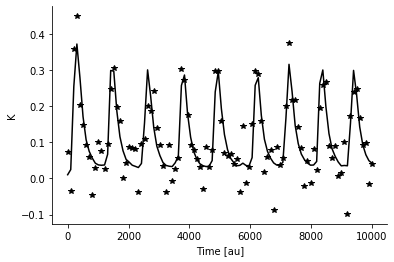

In [1]:
import pyabc
from study_abc_noise.model import HodgkinHuxleyModelVars as ModelVars
import numpy as np
import scipy.stats as stats
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import logging
import pickle
%matplotlib inline

# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Acceptor')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Epsilon')
df_logger.setLevel(logging.DEBUG)

n_t = 100
# basedir must point to an installation of the model
mv = ModelVars(n_t=n_t, basedir='/home/icb/yannik.schaelte/Study-ABC-Noise/study_abc_noise/')
#mv = ModelVars(n_t=n_t, basedir="..", noise_std=0.05)
mv.limits = {'dc': (18, 25), 'membrane_dim': (5, 15)}

# model
model = mv.get_model()
model_noisy = mv.get_model_noisy()

prior = mv.get_prior()
distance = mv.get_distance()
kernel = mv.get_kernel()
acceptor = pyabc.StochasticAcceptor()
eps = pyabc.Temperature()

#sampler = pyabc.sampler.RedisEvalParallelSampler(host="icb-mona", port=8775, batch_size=10)
sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs=20)

# data
def get_data():
    try:
        data_nonoise, data = pickle.load(open(f"data_{n_t}.dat", 'rb'))
    except:
        data_nonoise = model(mv.p_true)
        data = mv.add_noise_to_data(data_nonoise)
        pickle.dump((data_nonoise, data), open(f"data_{n_t}.dat", 'wb'))
    return data_nonoise, data

data_nonoise, data = get_data()

fig, ax = plt.subplots()
ax.plot(data_nonoise['K'], '-', color='k')
ax.plot(data['K'], '*', color='k')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.set_size_inches((6,4))
ax.set_xlabel("Time [au]")
ax.set_ylabel("K")

for fmt in ['svg', 'eps']:
    plt.savefig(f"data_{n_t}.{fmt}", format=fmt)

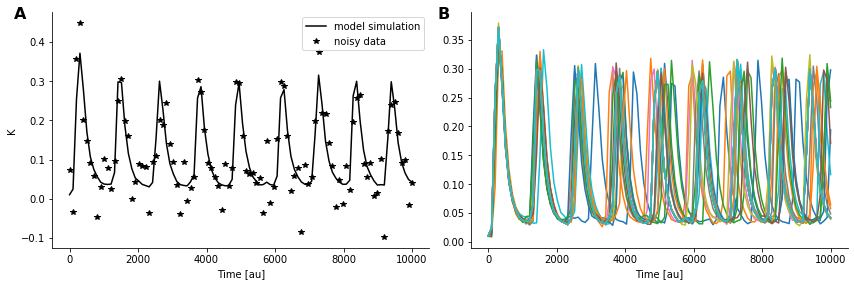

In [2]:
fig, arr_ax = plt.subplots(1,2)

ax = arr_ax[0]
ax.plot(data_nonoise['K'], '-', color='k', label="model simulation")
ax.plot(data['K'], '*', color='k', label="noisy data")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Time [au]")
ax.set_ylabel("K")
ax.legend()

ax = arr_ax[1]
_model = ModelVars(n_t=n_t, basedir='..').get_model()
for _ in range(20):
    ax.plot(_model(mv.p_true)['K'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Time [au]")
ax.set_ylabel(None)

fig.set_size_inches((12,4))

plt.figtext(0.02, 0.94, "A", size=16, weight='bold')
plt.figtext(0.51, 0.94, "B", size=16, weight='bold')

fig.tight_layout()

for fmt in ['svg', 'eps', 'pdf']:
    plt.savefig(f"data_and_model_trajectories.{fmt}", format=fmt)

In [ ]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=1000, sampler=sampler)
abc.new(f"sqlite:///h_incorrect_{n_t}.db", data)
abc.run(max_nr_populations=15, min_acceptance_rate=1e-4)

In [ ]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=1000)
abc.new(f"sqlite:///h_exact_{n_t}.db", data_nonoise)
abc.run(max_nr_populations=15, min_acceptance_rate=1e-4)

In [ ]:
abc = pyabc.ABCSMC(model, prior, kernel, eps=eps, acceptor=acceptor, population_size=1000)
abc.new(f"sqlite:///h_stochacc_{n_t}.db", data)
abc.run()

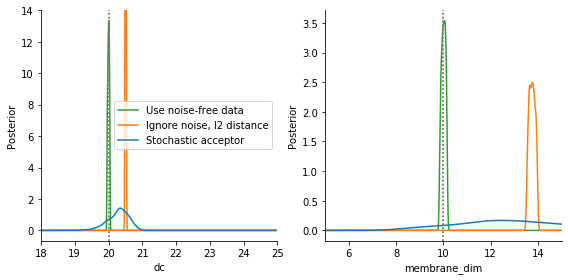

In [3]:
import pyabc
%matplotlib inline

def plot(h, x, ax, limits, p_true):
    for t in range(0, h.max_t + 1):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, t=t, x=x, xmin=limits[x][0], xmax=limits[x][1], ax=ax,
            refval=p_true, label=f"Iter. {t}")
    ax.legend()
    return ax

#h_exact = pyabc.History(f"sqlite:///h_incorrect_{noise_model}_exactdata.db")
h_incorrect = pyabc.History(f"sqlite:///h_incorrect_100.db")
h_exact = pyabc.History("sqlite:///h_exact_100.db")
h = pyabc.History(f"sqlite:///h_stochacc_100.db")

fig, arr_ax = plt.subplots(1,2)
for ip, p in enumerate(mv.p_true):
    ax = arr_ax[ip]
    for i, (h, label) in enumerate([(h_exact, "Use noise-free data"), (h_incorrect, "Ignore noise, l2 distance"), (h, "Stochastic acceptor")]):
        pyabc.visualization.plot_kde_1d_highlevel(h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], ax=ax,
                                                  refval=mv.p_true, refval_color='grey',
                                                  label=label, numx=500, color=f'C{2-i}')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
arr_ax[0].legend()
fig.set_size_inches((8,4))
fig.tight_layout()
for fmt in ['svg', 'eps', 'pdf']:
    plt.savefig(f"kde_1d.{fmt}", format=fmt)
    
#for p in mv.p_true:
#    _, ax = plt.subplots()
#    plot(h_incorrect, p, ax, mv.limits, mv.p_true)
#    _, ax = plt.subplots()
#    plot(h, p, ax, mv.limits, mv.p_true)
#    ax.legend()

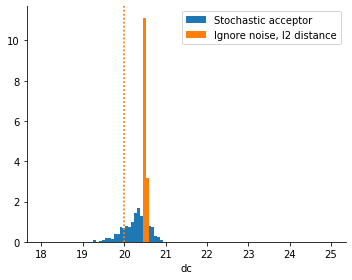

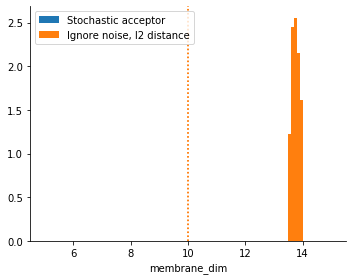

In [4]:
import pyabc
%matplotlib inline

def plot(h, x, ax, limits, p_true):
    for t in range(0, h.max_t + 1):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, t=t, x=x, xmin=limits[x][0], xmax=limits[x][1], ax=ax,
            refval=p_true, label=f"Iter. {t}")
    ax.legend()
    return ax

#h_exact = pyabc.History(f"sqlite:///h_incorrect_{noise_model}_exactdata.db")
h_incorrect = pyabc.History(f"sqlite:///h_incorrect_100.db")
h = pyabc.History(f"sqlite:///h_stochacc_100.db")

for p in mv.p_true:
    fig, ax = plt.subplots()
    for h, label in [(h, "Stochastic acceptor"), (h_incorrect, "Ignore noise, l2 distance")]:
        pyabc.visualization.plot_histogram_1d(h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], ax=ax,
                                         refval=mv.p_true, label=label, bins=100)
    ax.legend()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    fig.set_size_inches((5,4))
    fig.tight_layout()
    #ax.set_ylim(top=0.8)
    #for fmt in ['svg', 'eps']:
    #    plt.savefig(f"kde_1d_{p}_{noise_model}.{fmt}", format=fmt)
    
#for p in mv.p_true:
#    _, ax = plt.subplots()
#    plot(h_incorrect, p, ax, mv.limits, mv.p_true)
#    _, ax = plt.subplots()
#    plot(h, p, ax, mv.limits, mv.p_true)
#    ax.legend()

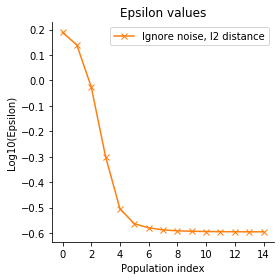

In [5]:
fig, ax = plt.subplots()
pyabc.visualization.plot_epsilons(h_incorrect, "Ignore noise, l2 distance", scale="log10", ax=ax)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_lines()[-1].set_color('C1')
ax.legend()
fig.set_size_inches((4,4))
fig.tight_layout()

for fmt in ['svg', 'eps']:
    plt.savefig(f'eps.{fmt}', format=f'{fmt}')


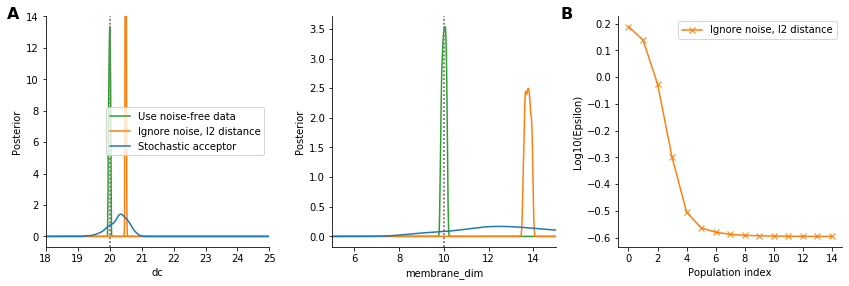

In [7]:
import pyabc
%matplotlib inline

def plot(h, x, ax, limits, p_true):
    for t in range(0, h.max_t + 1):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, t=t, x=x, xmin=limits[x][0], xmax=limits[x][1], ax=ax,
            refval=p_true, label=f"Iter. {t}")
    ax.legend(loc="upper left", bbox_to_anchor=(0.5, 0.5))
    return ax

#h_exact = pyabc.History(f"sqlite:///h_incorrect_{noise_model}_exactdata.db")
h_incorrect = pyabc.History(f"sqlite:///h_incorrect_100.db")
h_exact = pyabc.History("sqlite:///h_exact_100.db")
h = pyabc.History(f"sqlite:///h_stochacc_100.db")

fig, arr_ax = plt.subplots(1,3)
for ip, p in enumerate(mv.p_true):
    ax = arr_ax[ip]
    for i, (h, label) in enumerate([(h_exact, "Use noise-free data"), (h_incorrect, "Ignore noise, l2 distance"), (h, "Stochastic acceptor")]):
        pyabc.visualization.plot_kde_1d_highlevel(h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], ax=ax,
                                                  refval=mv.p_true, refval_color='grey',
                                                  label=label, numx=500, color=f'C{2-i}')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
arr_ax[0].legend()

ax = arr_ax[2]

pyabc.visualization.plot_epsilons(h_incorrect, "Ignore noise, l2 distance", scale="log10", ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title(None)
ax.get_lines()[-1].set_color('C1')
ax.legend()

fig.set_size_inches((12,4))

plt.figtext(0.02, 0.94, "A", size=16, weight='bold')
plt.figtext(0.66, 0.94, "B", size=16, weight='bold')

fig.tight_layout()

for fmt in ['svg', 'eps', 'pdf']:
    plt.savefig(f"motivation_hh_combined.{fmt}", format=fmt)
    
#for p in mv.p_true:
#    _, ax = plt.subplots()
#    plot(h_incorrect, p, ax, mv.limits, mv.p_true)
#    _, ax = plt.subplots()
#    plot(h, p, ax, mv.limits, mv.p_true)
#    ax.legend()